In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def obtain_dos_from_gaussian_pdf(energy_grid, eigvals_all, 
                                 efermi=0.0, e_resolution=1e-3):
    '''
    Obtain the density of states from the Gaussian PDF of the eigenvalues.
    '''
    eigvals_all_flat = eigvals_all.reshape(-1)-efermi
    energy_grid = energy_grid - efermi
    dos = gaussian_kde(eigvals_all_flat, bw_method=e_resolution)
    dos = dos(energy_grid)
    # normalize the DOS
    dos /= np.sum(dos)
    return dos


In [3]:
# collect all the dos
# efermi has been shifted to be 0

eigsfile = "./data/bulk_uniform_sampled_BZ_efields.h5"
efields_to_plot = [0.0, 0.05, 0.1, 0.15, 0.2]
emin = -0.2; emax = 0.2
ne_pts = 1001
e_resolution = 2e-3
energy_grid = np.linspace(emin, emax, ne_pts)

with h5py.File(eigsfile, "r") as f,\
     h5py.File("./data/dos_efields.h5", 'w') as f_out:
        # read in the eigvals for each efield
        for efield in efields_to_plot:
            eigvals_e = f[f"e{efield}/eigvals"][()]
            dos_e = obtain_dos_from_gaussian_pdf(energy_grid,
                                                eigvals_e, 
                                                e_resolution = e_resolution)
            f_out.create_dataset(f"e{efield}/energy_grid", data=energy_grid)
            f_out.create_dataset(f"e{efield}/e_resolution", data=e_resolution)
            f_out.create_dataset(f"e{efield}/dos", data=dos_e)


In [4]:
# we also want to find the position of the splitted band edges 
# from the band dispersion data
cbm1, cbm2 = {}, {}
bands_hdf5_file = "./data/bulk_bands_efields.h5"
with h5py.File(bands_hdf5_file, 'r') as f:
    for efield in efields_to_plot:
        cbm1[efield], cbm2[efield] = f[f"e{efield}/cbm1"][()], f[f"e{efield}/cbm2"][()]

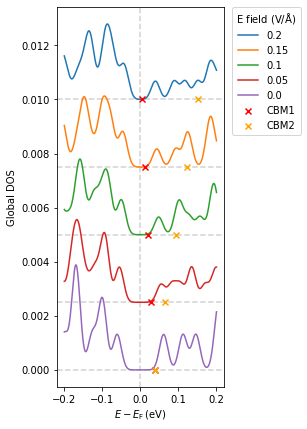

In [5]:
# plot the dos vs efield
fig, ax = plt.subplots(1,1,figsize=(3, 7))

efields_to_plot = np.sort(efields_to_plot)[::-1]
yshifts = np.linspace(0.01, 0.0, len(efields_to_plot))

with h5py.File("./data/dos_efields.h5", 'r') as f:
    for efield, yshift in zip(efields_to_plot, yshifts):
        dos_e = f[f"e{efield}/dos"][()]
        egrid = f[f"e{efield}/energy_grid"][()]
        ax.plot(egrid, dos_e+yshift, 
                label=f"{efield}")
        ax.axhline(y=yshift, color='lightgrey', linestyle='--', zorder=-1)
        # annotate the cbm1 and cbm2 on the plot
        ax.scatter(cbm1[efield], yshift, color='red', marker='x', 
                   zorder=10, label='CBM1' if efield == 0.0 else None)
        ax.scatter(cbm2[efield], yshift, color='orange', marker='x', 
                   zorder=10, label='CBM2' if efield == 0.0 else None)
          
ax.set_xlabel(r"$E-E_{\mathrm{F}}\,$(eV)")
ax.set_ylabel("Global DOS")
ax.axvline(x=0, color='lightgrey', linestyle='--', zorder=-1)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.
          , title=r"E field (V/$\mathrm{\AA}$)")


fig.savefig("./figures/dos_efields.pdf", bbox_inches='tight')